## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv("D:/AMIR/Programming/Data Science/Sales Data Analysis/Online Retail.csv", encoding="latin", dtype={'CustomerID': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


- Just by looking at the first 5 rows of our table, we can understand the structure and datatypes present in our dataset. 
- We can notice that we will have to deal with time series data, integers and floats, and categorical, and text data.

## Exploratory data analysis

- Every data science project starts with EDA as we have to understand what do we have to deal with. 
- I divide EDA into 2 types: visual and numerical. Let's start with numerical as the simple pandas method .describe() gives us a lot of useful information.

### Quick statistical overview

In [3]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


- Just a quick look at data with the .describe() method gives us a lot of space to think. 
- We see negative quantities and prices, and we can see that not all records have CustomerID data.
- we can also see that the majority of transactions are for quantities from 3 to 10 items, majority of items have prices up to 5 pounds.
- we have a bunch of huge outliers we will have to deal with later.

### Dealing with types

- .read_csv() method performs basic type check, but it doesn't do that perfectly. 
- That's why it is much better to deal with data types in our dataframe before any modifications to prevent additional difficulties. 
- Every pandas dataframe has an attribute .dtypes which will help us understand what we currently have and what data has to be casted to correct types.

In [4]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

- If we have DateTime data it's better to cast it to DateTime type. 
- We don't touch InvoiceNo for now as it seems like data in this column has not only numbers. 
- we saw just the first 5 rows, while pandas during import scanned all the data and found that the type here is not numerical.

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.set_index('InvoiceDate')

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom


###  Dealing with null values

- Next and very important step is dealing with missing values.
- Normally if you encounter null values in the dataset you have to understand nature of those null values and possible impact they could have on the model. 

- There are few strategies that we can use to fix our issue with null values:

    - delete rows with null values
    - delete the feature with null values
    - impute data with mean or median values or use another imputing strategy (method .fillna())


- Let's check out what we have here.

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

- CustomerID has too many null values and this feature cannot predict a lot so we can just drop it.
-  It could be reasonable to create another feature "Amount of orders per customer".

In [8]:
df = df.drop(columns=['CustomerID'])

Let's check out what kind of nulls we have in Description:

In [9]:
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 11:52:00,536414,22139,NaN,56,0.0,United Kingdom
2010-12-01 14:32:00,536545,21134,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536546,22145,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536547,37509,NaN,1,0.0,United Kingdom
2010-12-01 14:34:00,536549,85226A,NaN,1,0.0,United Kingdom


- The data in these rows is pretty strange as UnitPrice is 0, so these orders do not generate any sales. 
- We can impute it with "UNKNOWN ITEM" at the moment and deal with those later during the analysis.

In [10]:
df['Description'] = df['Description'].fillna('UNKNOWN ITEM')
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64

### Checking out columns separately

- It makes sense to go feature by feature and check what pitfalls we have in our data and also to understand our numbers better.

- Let's continue checking the Description column. Here we can see items that were bought most often.

In [11]:
df['Description'].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

- Here we can see our best-selling products, items that appear in orders the most often. 
- To make it visually more appealing let's create a bar chart for 15 top items:

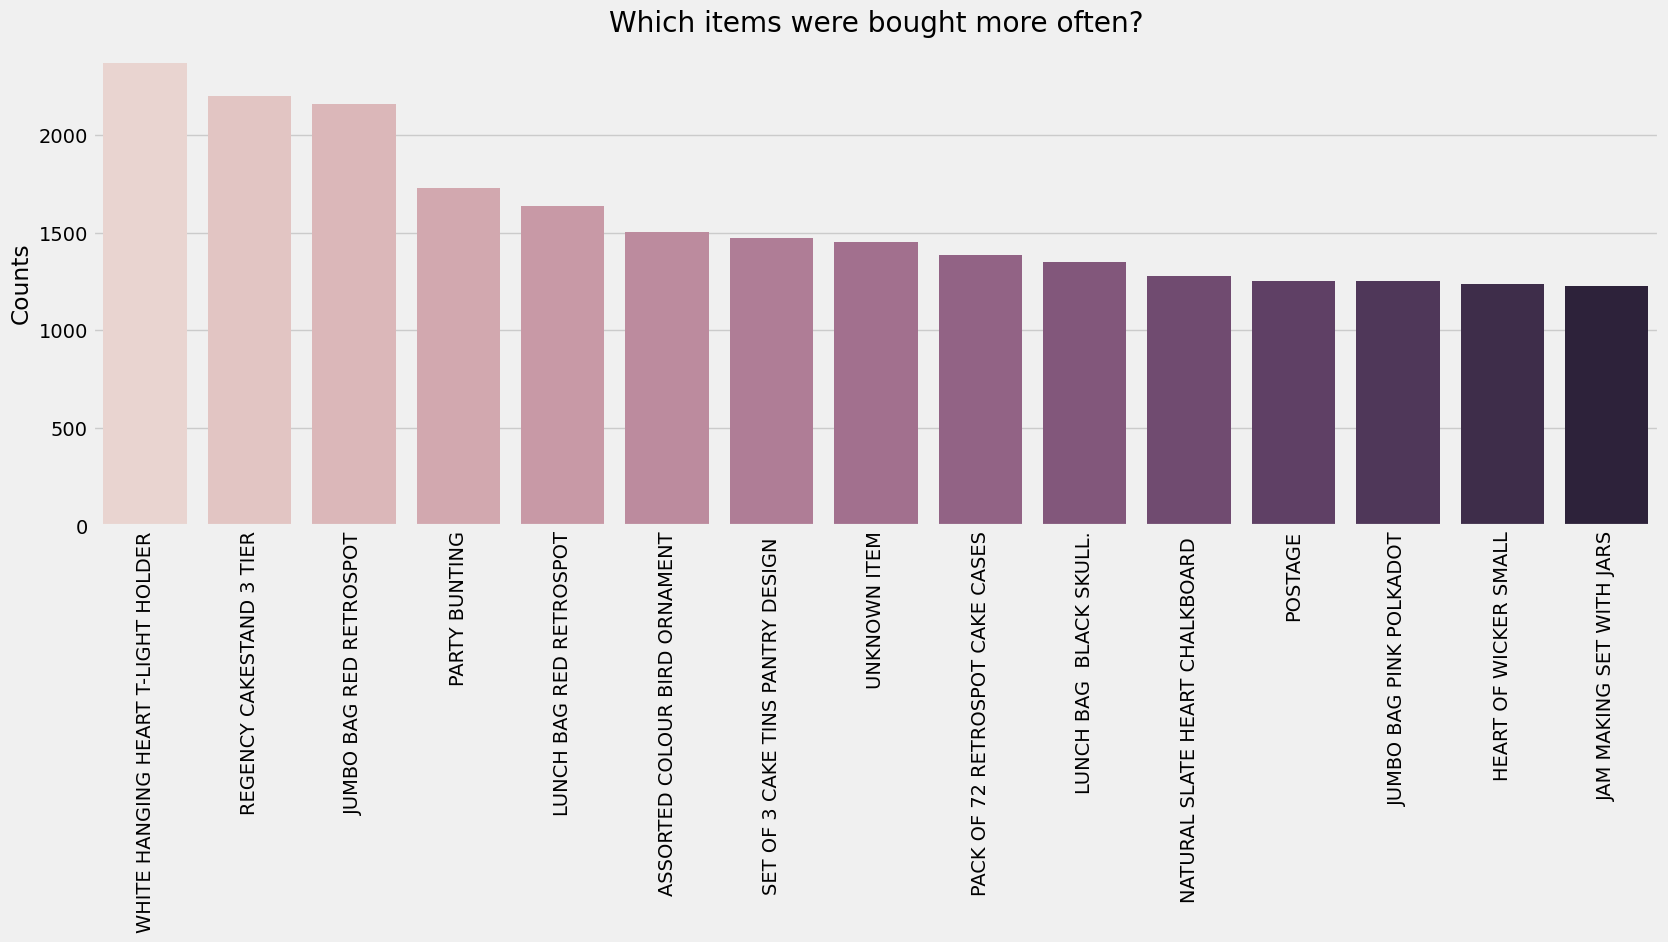

In [12]:
item_counts = df['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=item_counts.index, y=item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [13]:
df['Description'].value_counts().tail()

Missing                                1
historic computer difference?....se    1
DUSTY PINK CHRISTMAS TREE 30CM         1
WRAP BLUE RUSSIAN FOLKART              1
PINK BERTIE MOBILE PHONE CHARM         1
Name: Description, dtype: int64

- We also notice from the above code that valid items are normally uppercase and non-valid or cancelations are in lowercase.

In [14]:
df[~df['Description'].str.isupper()]['Description'].value_counts().head()

Manual                                572
BAG 125g SWIRLY MARBLES               304
BAG 250g SWIRLY MARBLES               252
3 TRADITIONAl BISCUIT CUTTERS  SET    240
POLYESTER FILLER PAD 40x40cm          193
Name: Description, dtype: int64

- Quick check of the case of letters in the Description says that there are some units with lowercase letters in their name and also that lowercase records are for canceled items.
- Here we can understand that data management in the store can be improved.

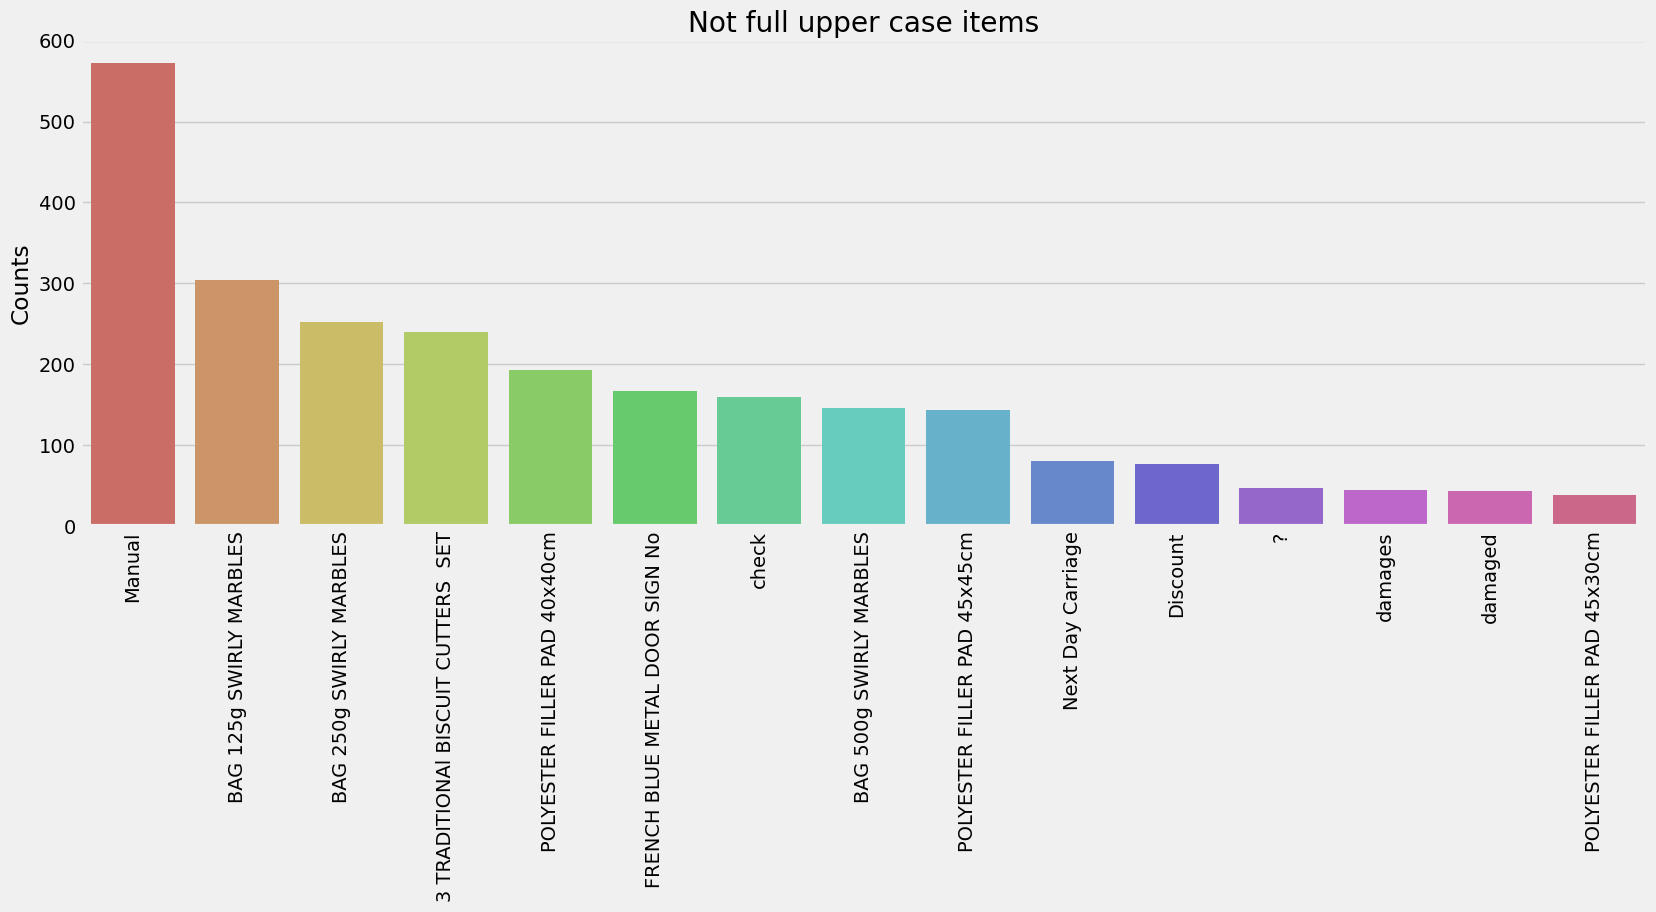

In [15]:
lcase_counts = df[~df['Description'].str.isupper()]['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=lcase_counts.index, y=lcase_counts.values, palette=sns.color_palette("hls", 15))
plt.ylabel("Counts")
plt.title("Not full upper case items");
plt.xticks(rotation=90);

- Checking out stoke codes, looks like they are deeply correlated with descriptions - which makes perfect sense.

In [16]:
df['StockCode'].value_counts().head()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: StockCode, dtype: int64

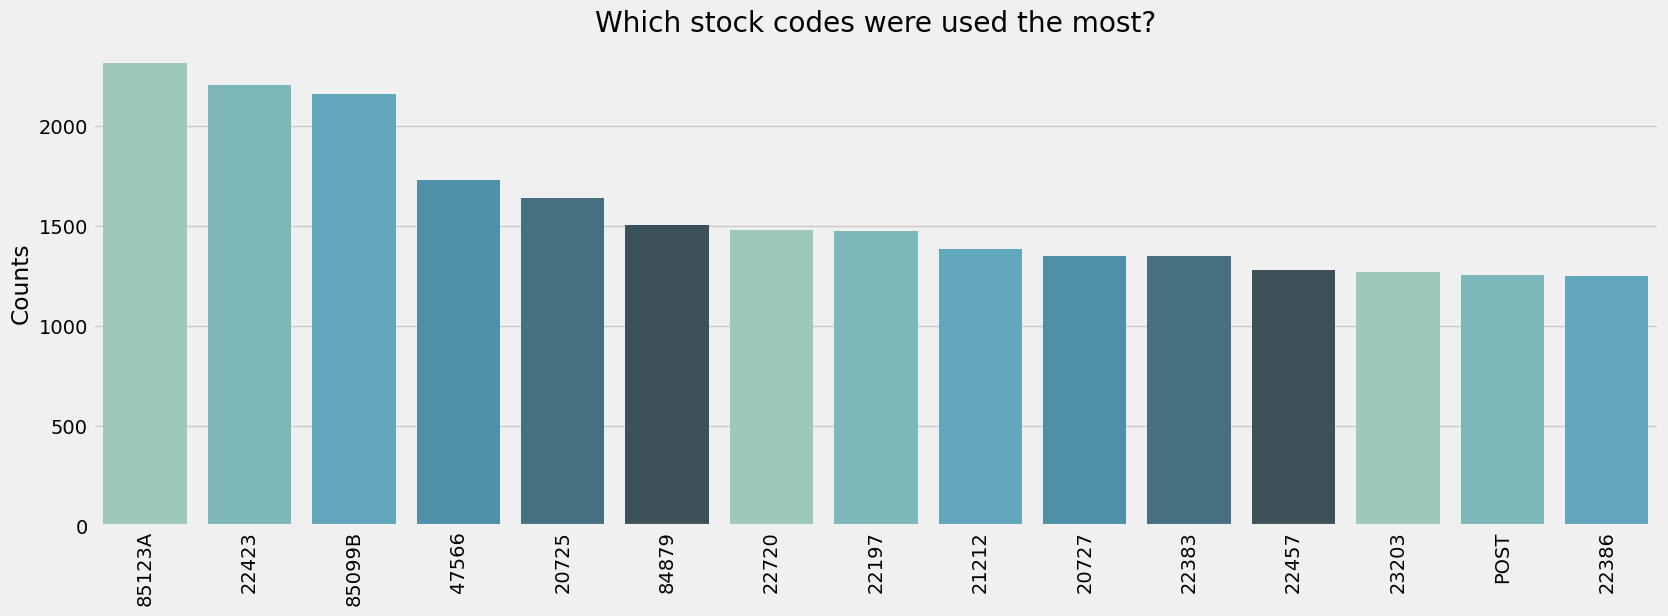

In [17]:
stock_counts = df['StockCode'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=stock_counts.index, y=stock_counts.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("Which stock codes were used the most?");
plt.xticks(rotation=90);

Checking out also InvoiceNo feature:

In [18]:
df['InvoiceNo'].value_counts().tail()

554023     1
554022     1
554021     1
554020     1
C558901    1
Name: InvoiceNo, dtype: int64

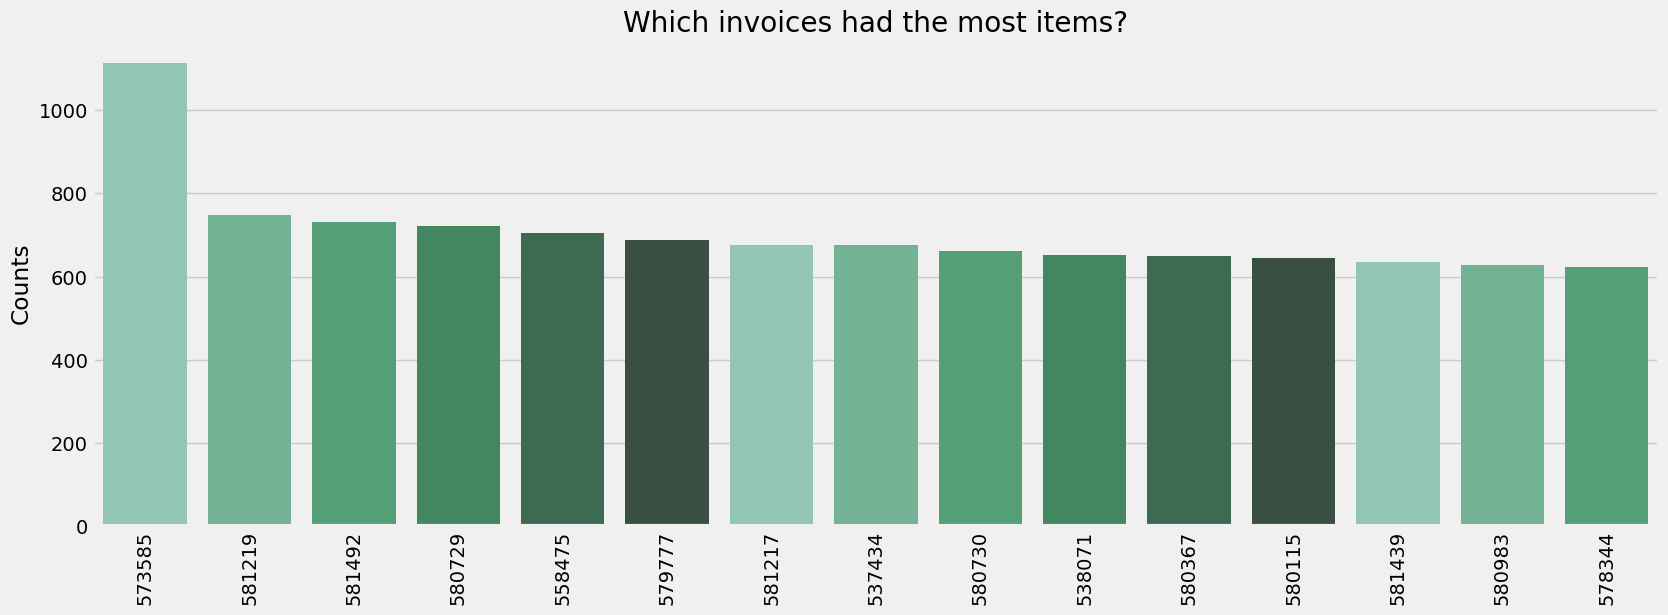

In [19]:
inv_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(x=inv_counts.index, y=inv_counts.values, palette=sns.color_palette("BuGn_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xticks(rotation=90);

In [20]:
df[df['InvoiceNo'].str.startswith('C')].describe()

,Quantity,UnitPrice
count,9288.000000,9288.000000
mean,-29.885228,48.393661
std,1145.786965,666.600430
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


- Looks like Invoices that start with 'C' are the "Canceling"/"Returning" invoices. This resolves the mystery of negative quantities.

- Although, we should've gotten deeper into the analysis of those returns, for the sake of simplicity let's just ignore those values for the moment.

- We can actually start a separate project based on that data and predict the returning/canceling rates for the store.

In [21]:
df = df[~df['InvoiceNo'].str.startswith('C')]

In [22]:
df.describe()

,Quantity,UnitPrice
count,532621.000000,532621.000000
mean,10.239972,3.847621
std,159.593551,41.758023
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- During exploratory data analysis we can go back to the same operations and checks, just to understand how our actions affected the dataset. 
- EDA is the series of repetitive tasks to understand better our data.
- Here, for example we get back to .describe() method to get an overall picture of our data after some manipulations.

- We still see negative quantities and negative prices, let's get into those records.

In [23]:
# df[df['Quantity'] < 0]
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 16:50:00,536589,21777,UNKNOWN ITEM,-10,0.0,United Kingdom
2010-12-02 14:42:00,536764,84952C,UNKNOWN ITEM,-38,0.0,United Kingdom
2010-12-03 15:30:00,536996,22712,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536997,22028,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536998,85067,UNKNOWN ITEM,-6,0.0,United Kingdom


- Here we can see that other "Negative quantities" appear to be damaged/lost/unknown items.
- Again, we will just ignore them for the sake of simplicity of analysis for this project.

In [24]:
df = df[df['Quantity'] > 0]
df.describe()

,Quantity,UnitPrice
count,531285.000000,531285.000000
mean,10.655262,3.857296
std,156.830323,41.810047
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- We also see negative UnitPrice, which is not normal as well. Let's check this out:

In [25]:
df[df['UnitPrice'] < 0].describe()

,Quantity,UnitPrice
count,2.0,2.00
mean,1.0,-11062.06
std,0.0,0.00
min,1.0,-11062.06
25%,1.0,-11062.06
50%,1.0,-11062.06
75%,1.0,-11062.06
max,1.0,-11062.06


In [26]:
df[df['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2011-08-12 14:51:00,A563186,B,Adjust bad debt,1,-11062.06,United Kingdom
2011-08-12 14:52:00,A563187,B,Adjust bad debt,1,-11062.06,United Kingdom


- As there are just two rows, let's ignore them for the moment (the description gives us enough warnings, although we still need some context to understand it better)

In [27]:
df = df[df['UnitPrice'] > 0]
df.describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- As we have finished cleaning our data and removed all suspicious records we can start creating some new features for our model. 
- Let's start with the most obvious one - Sales. 
- We have quantities, we have prices - we can calculate the revenue.

In [28]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34


### Visual EDA

(array([0]), [Text(0, 0, 'United Kingdom')])

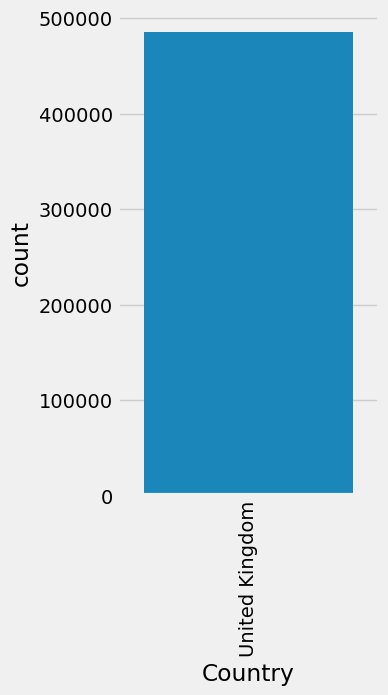

In [29]:
plt.figure(figsize=(3,6))
sns.countplot(x=df[df['Country'] == 'United Kingdom']['Country'])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 [Text(0, 0, 'France'),
  Text(1, 0, 'Australia'),
  Text(2, 0, 'Netherlands'),
  Text(3, 0, 'Germany'),
  Text(4, 0, 'Norway'),
  Text(5, 0, 'EIRE'),
  Text(6, 0, 'Switzerland'),
  Text(7, 0, 'Spain'),
  Text(8, 0, 'Poland'),
  Text(9, 0, 'Portugal'),
  Text(10, 0, 'Italy'),
  Text(11, 0, 'Belgium'),
  Text(12, 0, 'Lithuania'),
  Text(13, 0, 'Japan'),
  Text(14, 0, 'Iceland'),
  Text(15, 0, 'Channel Islands'),
  Text(16, 0, 'Denmark'),
  Text(17, 0, 'Cyprus'),
  Text(18, 0, 'Sweden'),
  Text(19, 0, 'Finland'),
  Text(20, 0, 'Austria'),
  Text(21, 0, 'Bahrain'),
  Text(22, 0, 'Israel'),
  Text(23, 0, 'Greece'),
  Text(24, 0, 'Hong Kong'),
  Text(25, 0, 'Singapore'),
  Text(26, 0, 'Lebanon'),
  Text(27, 0, 'United Arab Emirates'),
  Text(28, 0, 'Saudi Arabia'),
  Text(29, 0, 'Czech Republic'),
  Text(30, 0, 'Canada'

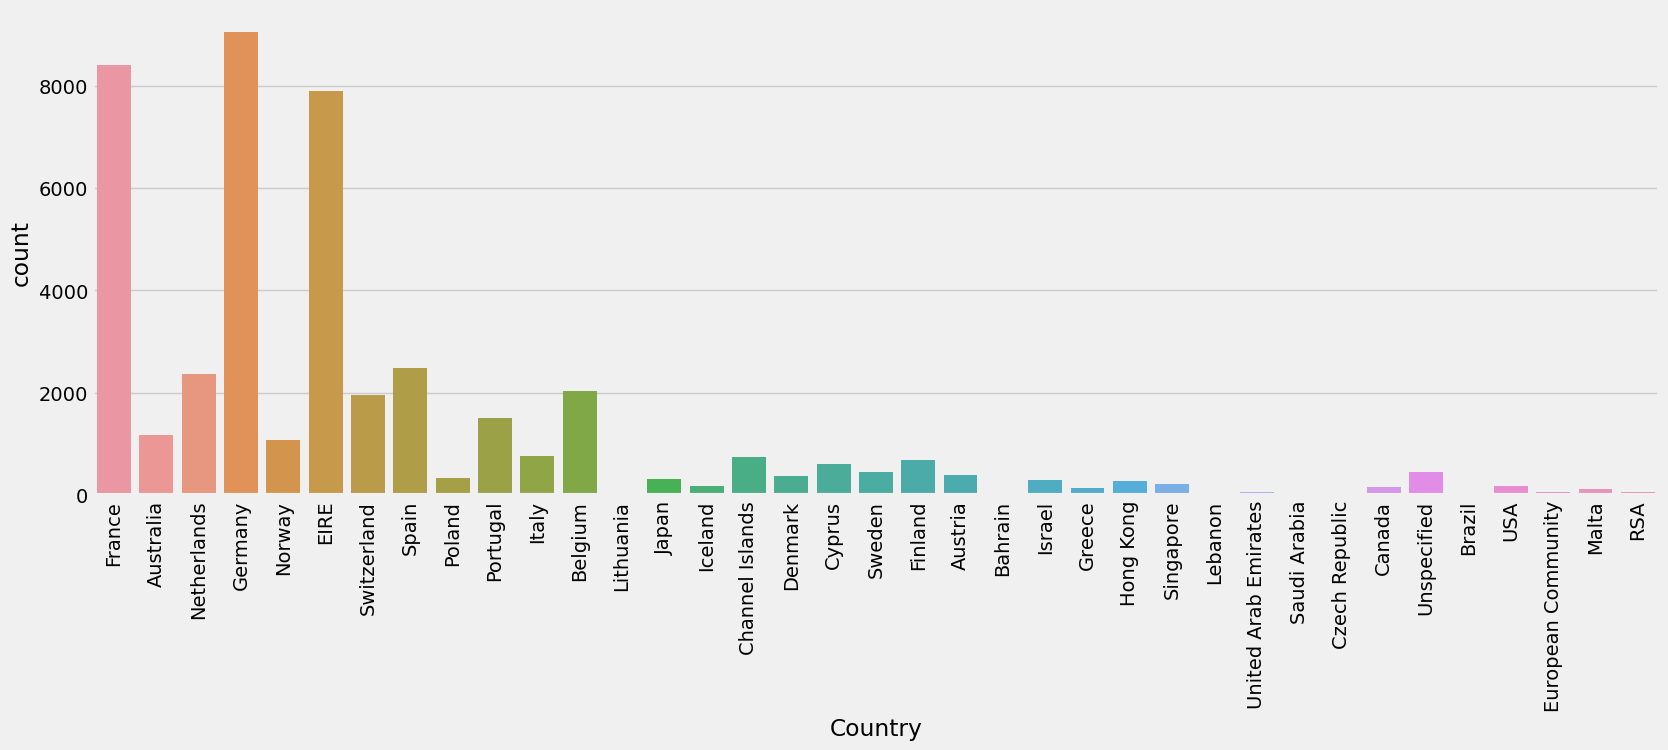

In [30]:
plt.figure(figsize=(18,6))
sns.countplot(x=df[df['Country'] != 'United Kingdom']['Country'])
plt.xticks(rotation=90)

In [31]:
uk_count = df[df['Country'] == 'United Kingdom']['Country'].count()
all_count = df['Country'].count()
uk_perc = uk_count/all_count
print(str('{0:.2f}%').format(uk_perc*100))

91.51%


- From the above plots and calculations, we can see that the vast majority of sales were made in the UK and just 8.49% went abroad.
- We can say our dataset is skewed to the UK side.

#### Detecting outliers

- There are a few different methods to detect outliers: 
    - box plots, 
    - using IQR, 
    - scatter plot also works in some cases (and this is one of those). 

- Detecting outliers using a scatter plot is pretty intuitive. You plot your data and remove data points that visually are definitely out of range. Like in the chart below:

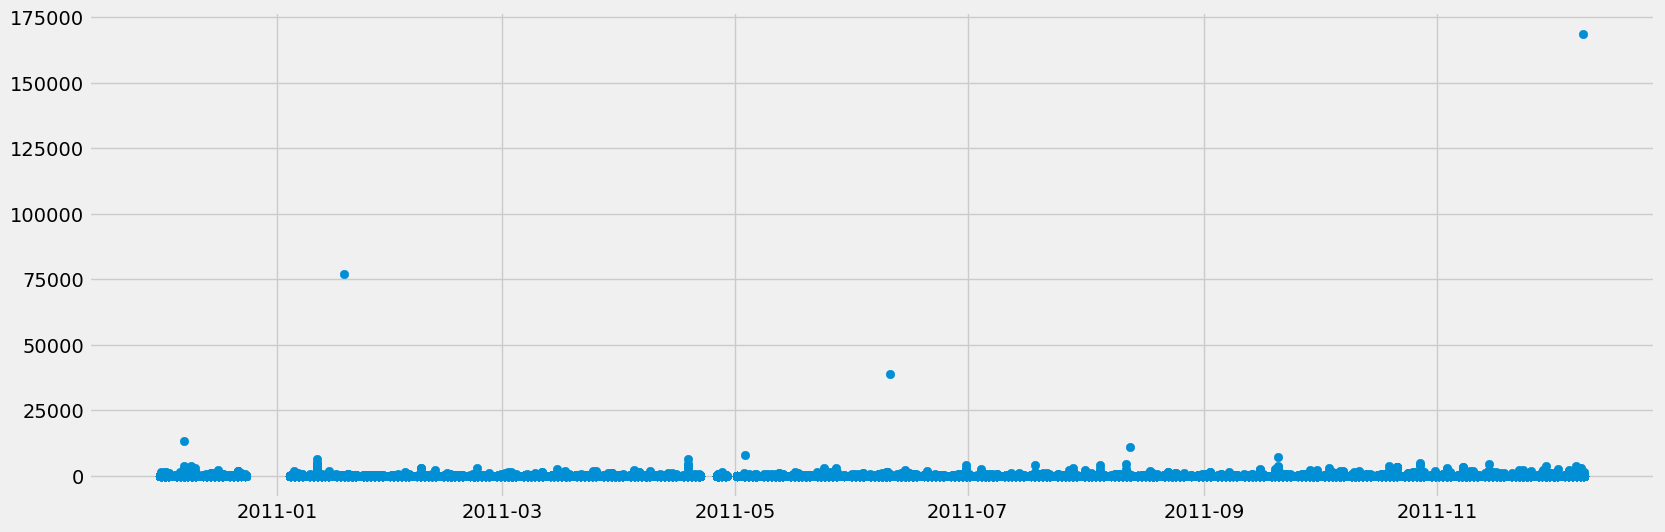

In [32]:
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])

####  Remove obvious outliers:

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

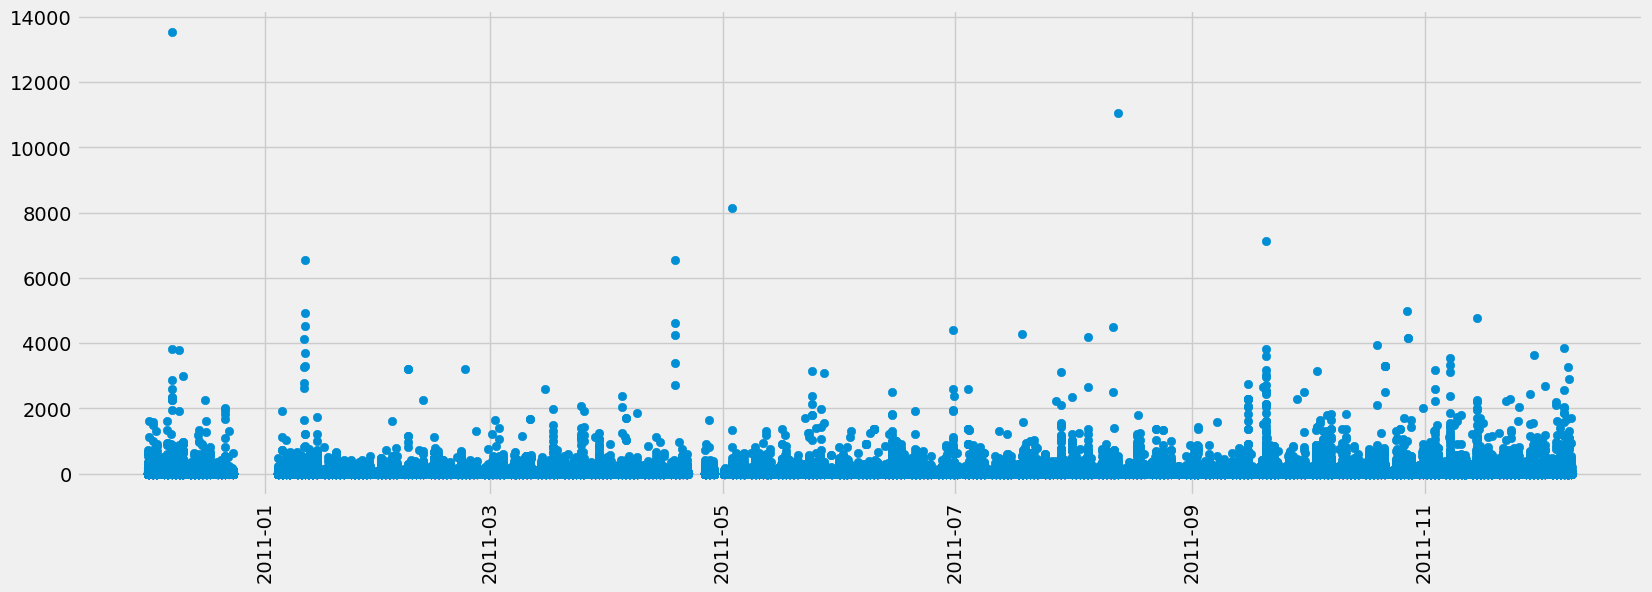

In [33]:
df = df[df['Sales'] < 25000]
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])
plt.xticks(rotation=90)

- After removing obvious outliers we still see some values that are out of normal distribution. 
- To understand better the distribution of our data let's check out different percentiles of our numeric features:

In [34]:
df.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice,Sales
0.050,1.0,0.42,1.25
0.950,30.0,9.95,59.70
0.980,72.0,14.95,121.68
0.990,100.0,16.98,183.60
0.999,446.4,165.00,833.79


- We can see that if we remove the top 2% of our data points we will get rid of absolute outliers and will have a more balanced dataset.

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

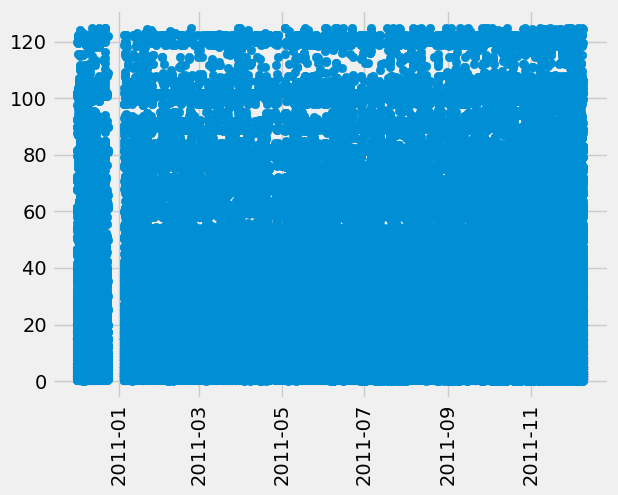

In [35]:
df_quantile = df[df['Sales'] < 125]
plt.scatter(x=df_quantile.index, y=df_quantile['Sales'])
plt.xticks(rotation=90)

In [36]:
df_quantile.describe()

,Quantity,UnitPrice,Sales
count,519958.000000,519958.000000,519958.000000
mean,7.850934,3.286582,13.850263
std,15.303867,3.949021,16.330954
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.080000,9.840000
75%,10.000000,4.130000,17.220000
max,1600.000000,124.870000,124.950000


- Looks like our data is almost ready for modelling. 
- We performed a clean up, we removed outliers that were disturbing the balance of our dataset, we removed invalid records.
- Now our data looks much better! and it doesn't lose it's value.